In [4]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries

import os
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

TISSUES="Adipose-Subcutaneous,Adipose-Visceral(Omentum),Artery-Aorta,Artery-Tibial,Brain-Caudate(basalganglia),Brain-Cerebellum,Cells-Transformedfibroblasts,Esophagus-Mucosa,Esophagus-Muscularis,Heart-LeftVentricle,Lung,Muscle-Skeletal,Nerve-Tibial,Thyroid,WholeBlood,Skin-NotSunExposed(Suprapubic),Skin-SunExposed(Lowerleg)"

# GLO1 promoter
#GENE="ENSG00000124767.6"
#CHROM=6
#START=38671094

# UTG1A1
#CHROM=2
#START=234668880
#GENE="ENSG00000241635.3" # check gene...

# MIF
#CHROM=22
#START=24235751
#GENE="ENSG00000240972.1"

# VLDLR - hematocrit ****
#CHROM=9
#START=2622147
#GENE="ENSG00000147852.11"

# PIG3
GENE="ENSG00000115129.9"
CHROM=2
START=24307212

# MMP9
GENE="ENSG00000100985"
CHROM=20
START=44637413

# EGFR
GENE="ENSG00000146648.11"
CHROM=7
START=55088254

# NOS3
GENE="ENSG00000164867"
CHROM=7
START=150699472

# IFNG
CHROM=12
START=68552495
GENE="ENSG00000111537.4"

# HMGA2
CHROM=12
START="66218489"
GENE="ENSG00000149948.9"

# CSTB
CHROM=21
START=45196326
GENE="ENSG00000160213.5"

# ADAM12
CHROM=10
GENE="ENSG00000148848.10"
START=127831854

#MYBL2
CHROM=20
GENE="ENSG00000101057.11"
START=42491265

Populating the interactive namespace from numpy and matplotlib


In [5]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz 

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GB\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

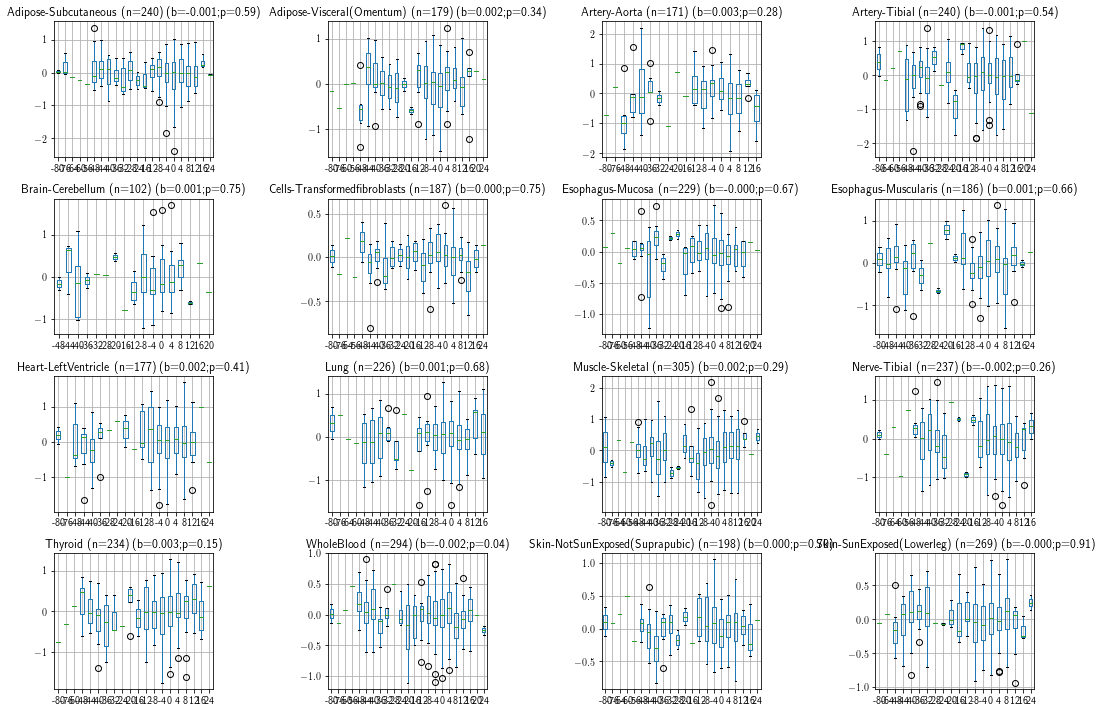

In [6]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

fig = plt.figure()
fig.set_size_inches((15, 10))
fignum = 1

for t in TISSUES.split(","):
    if "Caudate" in t: continue
    expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
    data = pd.merge(strgt, expr)
    ax = fig.add_subplot(4, 4, fignum)
    data.boxplot(column="expr", by="str", ax=ax);
    X = np.array(data["str"])
    X = sm.add_constant(X)
    Y = np.array(data["expr"])
    model = sm.OLS(Y,X)
    res = model.fit()
    p = res.pvalues[1]
    beta = res.params[1]
    ax.set_xlabel("", size=12)
    ax.set_ylabel("", size=12)
    ax.set_title(t + " (n=%s) (b=%.3f;p=%.2f)"%(data.shape[0], beta, p))
    plt.suptitle("");
    fignum += 1
plt.tight_layout()

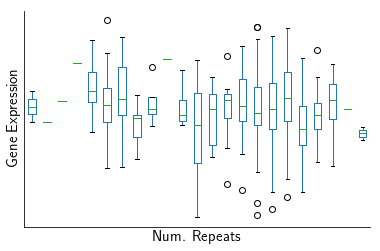

In [7]:
# Plot single tissue
fig = plt.figure()
ax = fig.add_subplot(111)
t="WholeBlood"
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
data.boxplot(column="expr", by="str", ax=ax, grid=False);
ax.set_xlabel("Num. Repeats", size=15)
ax.set_ylabel("Gene Expression", size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.suptitle("");
plt.show()
fig.savefig("example_estr.pdf")